# Web Scraping solution


## Step 1: Install dependencies

In [2]:
pip install pandas requests

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Download HTML

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# URL 
url = "https://companies-market-cap-copy.vercel.app/index.html"

# Download HTML
response = requests.get(url)
if response.status_code != 200:
    raise Exception(f"Error al acceder a la página: {response.status_code}")
html_content = response.text

html_content

'\n<!DOCTYPE html>\n<html lang="en-US">\n<head>\n<title>Tesla (TSLA) - Revenue</title>\n<meta charset="utf-8"/>\n<link rel="shortcut icon" href="https://companiesmarketcap.com/favicon.ico" type="image/x-icon">\n<link rel="apple-touch-icon" sizes="57x57" href="/img/icons/apple-icon-57x57.png">\n<link rel="apple-touch-icon" sizes="60x60" href="/img/icons/apple-icon-60x60.png">\n<link rel="apple-touch-icon" sizes="72x72" href="/img/icons/apple-icon-72x72.png">\n<link rel="apple-touch-icon" sizes="76x76" href="/img/icons/apple-icon-76x76.png">\n<link rel="apple-touch-icon" sizes="114x114" href="/img/icons/apple-icon-114x114.png">\n<link rel="apple-touch-icon" sizes="120x120" href="/img/icons/apple-icon-120x120.png">\n<link rel="apple-touch-icon" sizes="144x144" href="/img/icons/apple-icon-144x144.png">\n<link rel="apple-touch-icon" sizes="152x152" href="/img/icons/apple-icon-152x152.png">\n<link rel="apple-touch-icon" sizes="180x180" href="/img/icons/apple-icon-180x180.png">\n<link rel="ic

## Step 3: Transform the HTML

In [3]:
# Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

In [4]:
# Extract the income table
table = soup.find("table")  

table


<table class="table" style="width:100%">
<thead>
<tr>
<th>Year</th>
<th>Revenue</th>
<th>Change</th>
</tr>
</thead>
<tbody>
<tr><td><span class="year">2024</span></td><td>$97.15 B</td><td class="percentage-green">0.39%</td></tr><tr><td><span class="year">2023</span> </td><td>$96.77 B</td><td class="percentage-green">18.8%</td></tr><tr><td><span class="year">2022</span></td><td>$81.46 B</td><td class="percentage-green">51.35%</td></tr><tr><td><span class="year">2021</span></td><td>$53.82 B</td><td class="percentage-green">70.67%</td></tr><tr><td><span class="year">2020</span></td><td>$31.53 B</td><td class="percentage-green">28.31%</td></tr><tr><td><span class="year">2019</span></td><td>$24.57 B</td><td class="percentage-green">14.52%</td></tr><tr><td><span class="year">2018</span></td><td>$21.46 B</td><td class="percentage-green">82.51%</td></tr><tr><td><span class="year">2017</span></td><td>$11.75 B</td><td class="percentage-green">67.98%</td></tr><tr><td><span class="year">2016</span

In [5]:
# Extract the rows 

rows = table.find_all("tr")

# Process table data
data = []
for row in rows[1:]:  # Skip the header row
    cols = row.find_all("td")
    date = cols[0].text.strip()
    revenue = cols[1].text.strip()
    data.append([date, revenue])

data

[['2024', '$97.15 B'],
 ['2023', '$96.77 B'],
 ['2022', '$81.46 B'],
 ['2021', '$53.82 B'],
 ['2020', '$31.53 B'],
 ['2019', '$24.57 B'],
 ['2018', '$21.46 B'],
 ['2017', '$11.75 B'],
 ['2016', '$7.00 B'],
 ['2015', '$4.04 B'],
 ['2014', '$3.19 B'],
 ['2013', '$2.01 B'],
 ['2012', '$0.41 B'],
 ['2011', '$0.20 B'],
 ['2010', '$0.11 B'],
 ['2009', '$0.11 B']]

In [6]:
# Create a DataFrame with the extracted data
df = pd.DataFrame(data, columns=["Date", "Revenue"])

# Sort the data by the 'Date' column in ascending order 
df = df.sort_values("Date")

df

,Date,Revenue
15,2009,$0.11 B
14,2010,$0.11 B
13,2011,$0.20 B
12,2012,$0.41 B
11,2013,$2.01 B
10,2014,$3.19 B
9,2015,$4.04 B
8,2016,$7.00 B
7,2017,$11.75 B
6,2018,$21.46 B


## Step 4: Process the DataFrame

In [7]:
# Clean and convert the income values to numbers
def convert_revenue(value):
    if "B" in value:
        edit_value = float(value.replace("B", "").replace("$", "").replace(",", ""))
        return edit_value


df["Revenue"] = df["Revenue"].apply(convert_revenue)

df["Revenue"]

15     0.11
14     0.11
13     0.20
12     0.41
11     2.01
10     3.19
9      4.04
8      7.00
7     11.75
6     21.46
5     24.57
4     31.53
3     53.82
2     81.46
1     96.77
0     97.15
Name: Revenue, dtype: float64

## Step 5: Store the data in sqlite

In [8]:
# Connect to SQLite and save the data
conn = sqlite3.connect("tesla_revenues.db")
cursor = conn.cursor()

In [13]:
# Create table in SQLite
cursor.execute("""
CREATE TABLE IF NOT EXISTS revenue (
    date TEXT,
    revenue REAL
)
""")

In [14]:
# Insert data into the database
for index, row in df.iterrows():
    cursor.execute("INSERT INTO revenue (date, revenue) VALUES (?, ?)", (row["Date"], row["Revenue"]))

conn.commit()
conn.close()

## Step 6: Visualize the data

### Time serie visualization

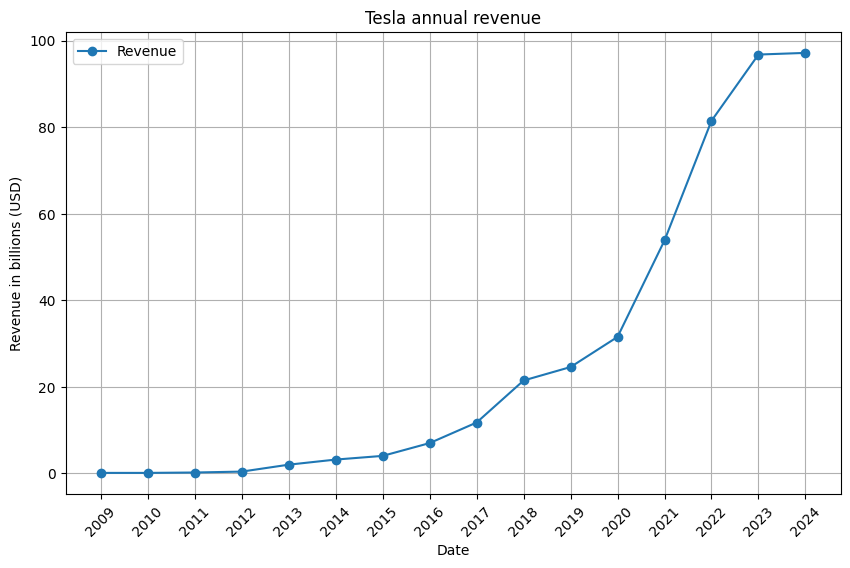

In [15]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Revenue"], marker='o', label="Revenue")
plt.title("Tesla annual revenue")
plt.xlabel("Date")
plt.ylabel("Revenue in billions (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Save and display the chart
plt.savefig("revenue_plot.png")
plt.show()


## Extra 

Using the libraries mentioned earlier, extract Tesla's earnings from the last year from the following URL: https://companies-market-cap-copy.vercel.app/earnings.html

Note: This time, we have chosen to write the entire code as a single block. This is how it would appear in a Python script rather than in a Jupyter Notebook.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL 
url = "https://companies-market-cap-copy.vercel.app/earnings.html"

# Make the request to the page
response = requests.get(url)
response.raise_for_status() 

# Parse the HTML content
html = BeautifulSoup(response.text, "html.parser")

# Extract the annual earnings table
table = html.find("table", {"class": "table"}) 
rows = table.find_all("tr")[1:] 

# Extract data and convert it into lists
data = []
for row in rows:
    columns = row.find_all("td")
    year = columns[0].text.strip() 
    earnings = columns[1].text.strip()  
    data.append({"Year": year, "Earnings": earnings})

# Create a DataFrame with the data
df = pd.DataFrame(data)

# Convert earnings to numeric values
def parse_earnings(value):
    try:
        value = value.replace(",", "").replace("$", "").strip()
        if "Billion" in value: 
            return float(value.replace("Billion", "")) * 1_000_000_000
        elif "Million" in value:
            return float(value.replace("Million", "")) * 1_000_000_000
        elif "M" in value:  
            return float(value.replace("M", "")) * 1_000_000
        elif "B" in value:
            return float(value.replace("B", "")) * 1_000_000_000
        else:
            return float(value)
    except ValueError:
        print(f"Warning: Could not convert the value '{value}'. Setting it as NaN.")
        return float("nan") 

# Clean the 'Year' column
def clean_year(value):
    try:
        return int(value.split()[0]) 
    except ValueError:
        print(f"Warning: Could not process the year value '{value}'. Setting it as NaN.")
        return float("nan")  

df["Earnings"] = df["Earnings"].apply(parse_earnings)
df["Year"] = df["Year"].apply(clean_year)

df = df.sort_values("Year", ascending=False)

# Get the row for the most recent year and its earnings
last_year_row = df.iloc[0]  

# Extract the specific year from that row
last_year = int(last_year_row["Year"])

menssage = f"Tesla has generated ${last_year_row['Earnings']:,.2f} in earnings in the year {last_year}."

# Display the result
print(menssage)

Tesla has generated $8,730,000,000.00 in earnings in the year 2024.
